In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed  # parralélisation des calculs pour gain de temps

# Méthode 1 : Approche par Monte Carlo

Pour chaque valeur de sigma $\sigma$, on estime $\Phi(x,0,\sigma)$. Pour ce faire, nous proposons une approche Monte Carlo, à savoir en moyennant de nombreuses simulations $\sigma$ simulées selon une loi normale pour estimer le Best Estimate moyen.

### Initialisation des paramètres 

In [470]:
x_infini = 0
T = 3
k = 0.3
mu = 0.01
nu = 0.01
sigma = 0.01

### Simulation du processus gaussien de retour à la moyenne x

In [391]:
def gaussian_process(x_initial, k, x_infini, sigma, T):
    
    x = np.zeros(T+1)
    x[0] = x_initial
    
    for indice, i in enumerate(range(T)):    
        
        x[indice+1] = (x[indice] + k*(x_infini-x[indice]) + sigma*np.random.normal()) # formule discrète de x retour à la moyenne
        
    return(x)

### Simulation du contrat par le théorème de Feynman Kac

In [392]:
def phi(x_initial, k, x_infini, sigma, T, n, mu, nu):
    
    val = []
    for i in range(n):
        x = gaussian_process(x_initial, k, x_infini, sigma, T)
        val.append(np.exp(np.sum(x+(1-(mu-nu*x)))/T)) # formule discrète du théorème
        
    return(np.mean(val)) # espérence conditionnelle de la formule simulée par Monte Carlo

### Determination du Best Estimate via Feynman Kac sur une grille de x

In [393]:
espace = np.arange(-5, 5, 0.05)
res = []

for i in espace :
    
    liste_de_sigma = np.random.normal(0.01,0.01, 100)  #valeurs suggérées
    val = []

    for sigma in liste_de_sigma :

        val.append(phi(i, k, x_infini, sigma, T, nb_estimation, mu, nu))
    res.append(np.mean(val))

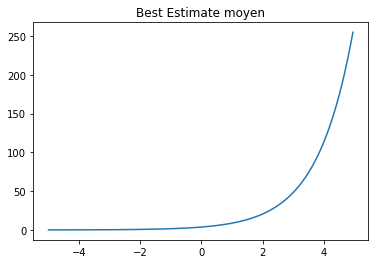

In [394]:
plt.plot(espace, res)
plt.title("Best Estimate moyen")
plt.show()

## Estimation des ajustements pour incertitudes

In [442]:
def Ajustement(q, res, x):
    
    val = []
    for i in (res-q):
        if i>0 :
            val.append(i)
    print("L'ajustement pour incertitude de quantile {} pour x = {} vaut : {}".format(q, x, np.mean(val)))

In [443]:
x = -1
res = []

for i in range(1000) :
    
    sigma = np.random.normal(0.01,0.01)  #valeurs suggérées par le professeur
    res.append(phi(x, k, x_infini, sigma, T, 1000, mu, nu))
    
res = np.array(res)

In [444]:
Ajustement(np.percentile(res, 90), res, -1)  # Ajustement pour une certaine valeure de x 
Ajustement(np.percentile(res, 95), res, -1)
Ajustement(np.percentile(res, 99), res, -1)

L'ajustement pour incertitude de quantile 1.596672258699584 pour x = -1 vaut : 0.0007631383625826182
L'ajustement pour incertitude de quantile 1.597129486275557 pour x = -1 vaut : 0.0008642019798697875
L'ajustement pour incertitude de quantile 1.5983590460683237 pour x = -1 vaut : 0.001271620488407832


In [445]:
x = 0
res = []

for i in range(1000) :
    
    sigma = np.random.normal(0.01,0.01)  #valeurs suggérées par le professeur
    res.append(phi(x, k, x_infini, sigma, T, 1000, mu, nu))
    
res = np.array(res)

In [446]:
Ajustement(np.percentile(res, 90), res, 0)  # Ajustement pour une certaine valeure de x 
Ajustement(np.percentile(res, 95), res, 0)
Ajustement(np.percentile(res, 99), res, 0)

L'ajustement pour incertitude de quantile 3.7459341868792295 pour x = 0 vaut : 0.001885241949475347
L'ajustement pour incertitude de quantile 3.7470797757627397 pour x = 0 vaut : 0.002133603872329557
L'ajustement pour incertitude de quantile 3.750573763986396 pour x = 0 vaut : 0.0026791272289079073


## Determination du cout moyen de la garantie 

On fait varier nos x_i qui sont nos point de départ des chemins que l'on crée via l'équation de Feynman Kac.

In [402]:
x = np.linspace(-15,15,30)

In [403]:
liste_de_sigma = np.random.normal(0.01,0.01,1000)

for sigma in liste_de_sigma:
    
    res = []
    val = []
    for indice, x_i in enumerate(x):
        
        res.append(phi(x_i, k, x_infini, sigma, T, nb_estimation, mu, nu) -1)
        if(indice>0):
            if(res[indice]>0 and res[indice-1]<0):
                val.append(x_i)
                break
            
    
print("La valeur qui coupe 1 est donc quand x_i vaut : ", -np.mean(val))

La valeur qui coupe 1 est donc quand x_i vaut :  0.51724137931


Cette méthode s'avère efficace pour estimer le Best Estimate Moyen et le coût de la garantie. Par ailleurs cette méthode evite de passer par la discrétisation d'équations différentielles qui sont comme nous allons le voir très sensible aux points initiales. Cependant, cette méthode nécessite beaucoup de simulationsMonte Carlo

On propose donc par la suite de suivre la démarche proposé par l'exercice, à savoir la résolution d'une équation différentielle.


# Méthode 2 : Approche par projection de l'EDP

Désormais nous développons l'approche EDP pour calculer le best estimate moyen. Nous allons utiliser une méthode de différences finis classique du type :

$$\frac{\partial \Phi}{\partial t}(x,t)\approx \frac{\Phi(x,t)-\Phi(x,t-\Delta t)}{\Delta t}$$

On se repportera au rapport pour les détails de discrétisation.

In [447]:
x_infini = 0
K_0 = 0.3
d = 10
mu_0 = 0.04
mu = 0.01
eta = 2
nu = 0.01
T = 3

In [338]:
def initial_phi(d, espace, N):

    mat = np.zeros((d+1,N))
    mat[0,:] = 1
    return mat

def g(x, mu_0, eta): 
    
    return mu_0-eta*x

def rotation(dim): 
    
    mat = np.zeros((dim, dim))
    for i in range(1, dim):
        mat[i,i-1] = 1     # sous diagonale identité
    
    return mat

def mat_J(d, N): 
    
    return np.ones((d+1,N))

In [339]:
def mat_A(espace, pas_t, pas_x, k_0, x_infini, mu, mu_1, eta, N):
    
    a = [1-(mu**2*pas_t)/(pas_x**2)-(pas_t/(pas_x))*k_0*(x_infini-x)+ pas_t*(x+1-g(x,mu_1,eta)) for x in espace]
    b = [(mu**2/2)*(pas_t/(pas_x**2))+pas_t/(pas_x)*k_0*(x_infini-x) for x in espace[:-1]]
    c = (mu**2/2)*(pas_t/(pas_x**2))
    
    mat = np.zeros((N,N))  # matrice nulle
    mat[N-1,N-1] = a[N-1]  # dernière ligne derniere colonne
    for i in range(N-1):
        mat[i,i] = a[i]
        mat[i+1,i] = b[i]
        mat[i,i+1] = c
    
    return mat

def mat_B(pas_t, pas_x, nu, mu, d):
    
    a = -(nu**2)*pas_t/(pas_x**2)
    b = -2*nu*mu*pas_t/(pas_x**2)
    c = [-2*nu*mu*(k+1)*pas_t/(pas_x**2) for k in range(d)]
    e = [-(nu**2)*(k+2)*(k+1)*pas_t/(pas_x**2) for k in range(d-1)]
    
    mat = np.zeros((d+1,d+1))
   
    mat[d-1,d] = c[d-1]
    for i in range(0,d-1): # les sur diagonales
        mat[i,i+1] = c[i]
        mat[i,i+2] = e[i]
    
   
    mat[d,d-1] = b  # les sous diagonales
    for i in range(0,d-1):
        mat[i+1,i] = b
        mat[i+2,i] = a
    return mat

def mat_C(d, espace, pas_t, pas_x, nu, mu, N):

    c_k = [nu*mu*(k+1)*pas_t/(pas_x**2) for k in range(d+1)]
    mat = np.zeros((d+1,N))
    for i in range(N):
        mat[:,i] = c_k
    return mat

def mat_D(d, espace, pas_t, pas_x, nu, mu, N):
    
    d_k = [(nu**2)*(k+1)*(k+2)*pas_t/(pas_x**2) for k in range(d+1)]
    mat = np.zeros((d+1,N))
    for i in range(N):
        mat[:,i] = d_k
    return mat

def mat_E(d, espace, pas_t, pas_x, nu, mu, N): 

    e = [-(2*k+1)*(nu**2)*pas_t/(pas_x**2) for k in range(d+1)]
    mat = np.zeros((d+1,N))
    for i in range(N):
        mat[:,i] = e
    return mat

def mat_F(d, espace, pas_t, pas_x, nu, mu, N):
    
    f = [((2*k+1)*(nu**2)/2)*pas_t/(pas_x**2) for k in range(d+1)]
    mat = np.zeros((d+1,N))
    for i in range(N):
        mat[:,i] = f
    return mat

Nous allons essayer de trouver les bonnes variables d'espaces et de temps. On estime que nos variables d'espaces et de temps seront bien choisis lorsque notre PHI ne sera que positive. On test plusieurs valeurs:

In [481]:
# on fait une boucle pour determiner nos pas en temps et en espace optimaux afin que la solution converge

def cal(k, j, d):

        temps = np.arange(0, T, k)
        espace = np.arange(-5, 0.5, j)
        N=len(espace)
        
        # on initialise nos matrices
        
        Phi = initial_phi(d, espace, N)
        R_d = rotation(d+1)
        R_N = rotation(N)
        J = mat_J(d, N)

        
        A = mat_A(espace, k, j, K_0, x_infini, mu, mu_0, eta, N)
        B = mat_B(k, j, nu, mu, d)
        C = mat_C(d, espace, k, j, nu, mu, N)
        D = mat_D(d, espace, k, j, nu, mu, N)
        E = mat_E(d, espace, k, j, nu, mu, N)
        F = mat_F(d, espace, k, j, nu, mu, N)
        
        ## on resoud l'edp en "diffusant" sur le temps en itérant nos matrices phi
        
        for i in range(len(temps)):
            
            coef1 = np.dot(R_d, np.dot(R_d, np.dot(Phi, R_N)))+ np.dot(R_d, np.dot(R_d, np.dot(Phi, np.transpose(R_N))))
            coef2 = np.dot(R_d, np.dot(Phi, R_N))+ np.dot(R_d, np.dot(Phi, np.transpose(R_N)))
            coef3 = np.dot(np.transpose(R_d), np.dot(Phi, R_N))+ np.dot(np.transpose(R_d), np.dot(Phi, np.transpose(R_N)))
            coef4 = np.dot(np.transpose(R_d), np.dot(np.transpose(R_d), np.dot(Phi, R_N)))+ np.dot(np.transpose(R_d), np.dot(np.transpose(R_d), np.dot(Phi, np.transpose(R_N))))
            coef5 = np.dot(Phi, R_N)+ np.dot(Phi, np.transpose(R_N))  

            Phi = np.dot(Phi, A)+ np.dot(B, Phi)+ np.multiply(((nu**2)/2)*k/(j**2)*J, coef1)+ np.multiply(nu*mu*k/(j**2)*J, coef2)+ np.multiply(C, coef3)+ np.multiply(D, coef4)
            + np.multiply(E, Phi)+ np.multiply(F, coef5)
        
        print("Pour un pas en temps de {}, en espace de {}, la plus petite valeur de PHI est {}".format(k, j, np.min(Phi[0,:])))
        
        return Phi

In [121]:
delta = [1, 0.5, 0.1, 0.01, 0.05, 0.001]

for k in delta :
    Parallel(n_jobs=-1)(delayed(cal)(k,j) for j in delta)

Pour un pas en temps de 1, en espace de 1, la plus petite valeur de PHI est -136.03520086445238
Pour un pas en temps de 1, en espace de 0.5, la plus petite valeur de PHI est 63.211996052307406
Pour un pas en temps de 1, en espace de 0.1, la plus petite valeur de PHI est -2081733.5165595852
Pour un pas en temps de 1, en espace de 0.05, la plus petite valeur de PHI est -1954610775540.3992
Pour un pas en temps de 1, en espace de 0.01, la plus petite valeur de PHI est -1.1924864857923207e+20
Pour un pas en temps de 1, en espace de 0.001, la plus petite valeur de PHI est -3.886678519759222e+34
Pour un pas en temps de 0.5, en espace de 1, la plus petite valeur de PHI est -2364830.8440260836
Pour un pas en temps de 0.5, en espace de 0.5, la plus petite valeur de PHI est -350.7751989322639
Pour un pas en temps de 0.5, en espace de 0.1, la plus petite valeur de PHI est -1.5686227284845924e+18
Pour un pas en temps de 0.5, en espace de 0.05, la plus petite valeur de PHI est -9.369477035170316e+22

/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in multiply
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add


Pour un pas en temps de 0.1, en espace de 0.001, la plus petite valeur de PHI est nan
Pour un pas en temps de 0.01, en espace de 1, la plus petite valeur de PHI est 0.08738186193890565
Pour un pas en temps de 0.01, en espace de 0.5, la plus petite valeur de PHI est 0.00023177869630193243
Pour un pas en temps de 0.01, en espace de 0.1, la plus petite valeur de PHI est -221922434577460.38
Pour un pas en temps de 0.01, en espace de 0.05, la plus petite valeur de PHI est -9.30202811933151e+23


/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add


Pour un pas en temps de 0.01, en espace de 0.01, la plus petite valeur de PHI est nan


/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in multiply
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in add


Pour un pas en temps de 0.01, en espace de 0.001, la plus petite valeur de PHI est nan
Pour un pas en temps de 0.05, en espace de 1, la plus petite valeur de PHI est 0.07318059649637891
Pour un pas en temps de 0.05, en espace de 0.5, la plus petite valeur de PHI est 0.00019418582505579225
Pour un pas en temps de 0.05, en espace de 0.1, la plus petite valeur de PHI est -31390216734039.94
Pour un pas en temps de 0.05, en espace de 0.05, la plus petite valeur de PHI est -1.6238337783895123e+44
Pour un pas en temps de 0.05, en espace de 0.01, la plus petite valeur de PHI est -1.0107960651479575e+248


/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in multiply
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in add


Pour un pas en temps de 0.05, en espace de 0.001, la plus petite valeur de PHI est nan
Pour un pas en temps de 0.001, en espace de 1, la plus petite valeur de PHI est 0.09105259626885878
Pour un pas en temps de 0.001, en espace de 0.5, la plus petite valeur de PHI est 0.00024149307425335568
Pour un pas en temps de 0.001, en espace de 0.1, la plus petite valeur de PHI est -361290271674297.7
Pour un pas en temps de 0.001, en espace de 0.05, la plus petite valeur de PHI est -5.3894621024965155e+25


/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in add


Pour un pas en temps de 0.001, en espace de 0.01, la plus petite valeur de PHI est nan


/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in add
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in multiply
/Users/johnsibony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in add


Pour un pas en temps de 0.001, en espace de 0.001, la plus petite valeur de PHI est nan


Les Calculs prennent enormément de temps on garde les dernières valeurs à savoir, Delta_T = 0.001 et Delta_x = 0.5

In [482]:
Phi = cal(0.001, 0.5, d)

Pour un pas en temps de 0.001, en espace de 0.5, la plus petite valeur de PHI est 3.6805886142817613e-07


### Determination du Best Estimate

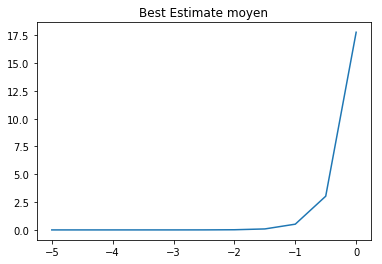

In [483]:
espace = np.arange(-5, 0.5, 0.5)
plt.plot(espace,Phi[0,:])
plt.title("Best Estimate moyen")
plt.show()

La solution à l'équation est stable et cohérente si le choix des paramètres est juste. Le choix des pas de temps et d'espace est primordial afin d'obtenir une convergence vers la solution qui soit stable. On a pu dans notre boucle plus haut, "reperer" une solution instable si les valeurs de Phi devenait trop importante.

### Simulation des polynômes de Hermittes

In [484]:
def Hermitte(d):

    xi = np.random.normal(0.01,0.01)
    poly = [1,xi]
    for i in range(2, d+1):
        poly.append(xi * poly_de_hermite[-1] - i * poly_de_hermite[-2])
        
    return poly

### Estimation des Ajustements pour Incertitude

In [485]:
print(espace)

[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0. ]


In [486]:
res = []

for j in range(1000):
    
    poly = np.array(Hermitte(d))
    val = np.dot(poly, Phi[:,10])  # La 8ème colonne de Phi_0 correspond au 8ème espavce x de espace ie à x=-1
    res.append(val)

In [487]:
Ajustement(np.percentile(res, 90), res, -1)  # Ajustement pour une certaine valeur de x 
Ajustement(np.percentile(res, 95), res, -1)
Ajustement(np.percentile(res, 99), res, -1)

L'ajustement pour incertitude de quantile 20.325522099237826 pour x = -1 vaut : 0.30135376105113826
L'ajustement pour incertitude de quantile 20.58106433870443 pour x = -1 vaut : 0.23330464933785308
L'ajustement pour incertitude de quantile 20.958870490924294 pour x = -1 vaut : 0.15509892985734516


In [488]:
res = []

for j in range(1000):
    
    poly = np.array(Hermitte(d))
    val = np.dot(poly, Phi[:,10])  # La 8ème colonne de Phi_0 correspond au 8ème espavce x de espace ie à x=-1
    res.append(val)

In [489]:
Ajustement(np.percentile(res, 90), res, 0)  # Ajustement pour une certaine valeur de x 
Ajustement(np.percentile(res, 95), res, 0)
Ajustement(np.percentile(res, 99), res, 0)

L'ajustement pour incertitude de quantile 20.328676133188313 pour x = 0 vaut : 0.3560444362892207
L'ajustement pour incertitude de quantile 20.599075304033583 pour x = 0 vaut : 0.30862866857524013
L'ajustement pour incertitude de quantile 21.148415637438415 pour x = 0 vaut : 0.20711756862457625


## Determination du cout moyen de la garantie 

In [492]:
res = []

for i in range(1000):
        
    poly = np.array(Hermitte(d))
    val = np.dot(poly, Phi)-1
    a = val[0]
    for indice, j in enumerate(val[1:]):
        if(j>0 and a<0):
            res.append(espace[indice])
            break
        a = j
    
print("La valeur qui coupe 1 est donc quand x vaut : ", -np.mean(res))

La valeur qui coupe 1 est donc quand x vaut :  1.0



Ainsi, on trouve un prix qui n'est pas celui annoncé par la méthode de Monte Carlo. On a beau modifier les valeurs de temps et d'espace, on n'arrive pas à retrouver la valeur de 0.5. Néanmoins on retrouve une valeur assez proche, à savoir 1. Cette différence n'est pas étonnante étant donné que les pas d'espace sont faibles (delta=0.5 impliquant que -x passe en particulier entre 0, 0.5 et 1.5 : il y a de trop grand saut)

### Discussion sur les discrétisations et sur les troncatures

Il est vraiment compliqué de trouver les bonnes valeurs de pas de temps et d'espace qui permettent d'assurer la stabilité de la solution. Une solution est dite stable si elle n'explose pas. Ce choix est important et on a pu observé des explosions assez rapides pour des mauvais choix de temps et d'espace. Par ailleurs, le choix de l'intervalle d'espace permet également d'avoir une convergence de la solution.

Enfin, nous proposons d'étudier l'impacte de la troncature en chaos d sur le prix du contrat Phi :



Pour un pas en temps de 0.001, en espace de 0.5, la plus petite valeur de PHI est 3.680588614280032e-07


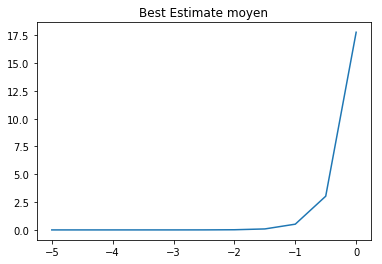

Pour un pas en temps de 0.001, en espace de 0.5, la plus petite valeur de PHI est 3.6805886142817613e-07


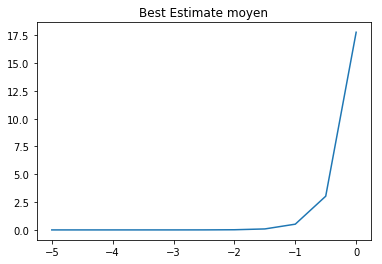

Pour un pas en temps de 0.001, en espace de 0.5, la plus petite valeur de PHI est 3.6805886142817613e-07


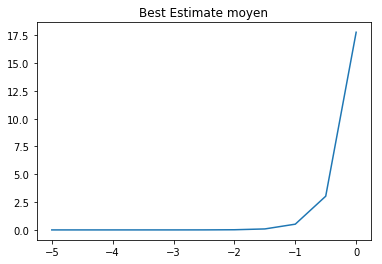

Pour un pas en temps de 0.001, en espace de 0.5, la plus petite valeur de PHI est 3.6805886142817613e-07


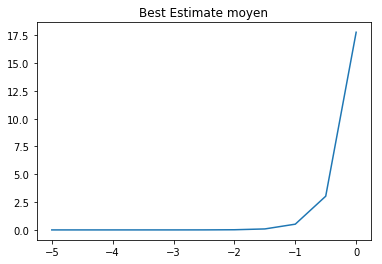

Pour un pas en temps de 0.001, en espace de 0.5, la plus petite valeur de PHI est 3.6805886142817613e-07


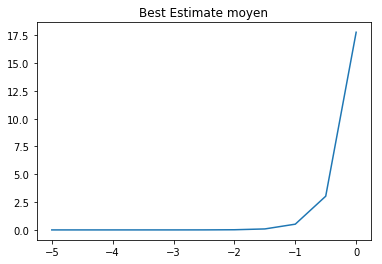

Pour un pas en temps de 0.001, en espace de 0.5, la plus petite valeur de PHI est 3.6805886142817613e-07


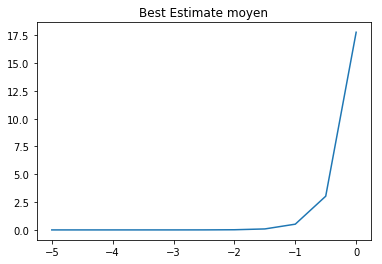

In [498]:
espace = np.arange(-5, 0.5, 0.5)

for d in [2,5,7,10,20,30]:
    
    espace = np.arange(-5, 0.5, 0.5)
    Phi = cal(0.001, 0.5, d)
    plt.plot(espace,Phi[0,:])
    plt.title("Best Estimate moyen")
    plt.show()

 On observe clairement qu'il n'y a pas de différence quant à la modification de d sur le Best Estimate qui est le prix du contrat en moyenne au temps initial.